,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4925325.8281,51339983401790.1484,6888097.3025,0.2591,0.0644,0.0454,0.1500
catboost,CatBoost Regressor,4946273.6826,40795120652438.8125,6277204.7697,0.3682,0.0579,0.0453,0.6100
ada,AdaBoost Regressor,5472311.6516,51010955823574.4375,6886493.0609,0.2385,0.0639,0.0499,0.0533
rf,Random Forest Regressor,5541127.0400,54968221439563.9766,7302429.5808,0.1445,0.0678,0.0507,0.1700
gbr,Gradient Boosting Regressor,6195010.1658,69719872716432.3828,8160397.7390,-0.0788,0.0763,0.0565,0.0333
xgboost,Extreme Gradient Boosting,6408864.0000,73075212506453.3281,8119935.5000,-0.1267,0.0761,0.0580,0.2267
lightgbm,Light Gradient Boosting Machine,6502045.0660,58715692408951.0547,7590940.6703,0.0393,0.0692,0.0593,0.0500
dummy,Dummy Regressor,6761397.1667,68877178372096.0000,8176986.8333,-0.0736,0.0748,0.0618,0.0167
dt,Decision Tree Regressor,7187486.2222,96618716693319.1250,9649164.2984,-0.6214,0.0913,0.0660,0.0167
knn,K Neighbors Regressor,7361510.0000,87535585853440.0000,9332743.0000,-0.6021,0.0867,0.0661,0.0167


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=597.661, Time=0.32 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=676.056, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=634.238, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=599.054, Time=0.22 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=614.827, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=599.409, Time=0.37 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=599.443, Time=0.61 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=600.727, Time=0.14 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=601.404, Time=0.97 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=630.453, Time=0.12 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=595.106, Time=0.28 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=609.656, Time=0.07 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=597.106, Time=0.58 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=597.106, Time=0.81 sec
 ARIMA(2,1,1)(1,1,0)[12]         

 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(4,1,0)(1,1,0)[12]             : AIC=502.184, Time=0.17 sec
 ARIMA(3,1,1)(1,1,0)[12]             : AIC=498.997, Time=0.33 sec
 ARIMA(3,1,1)(0,1,0)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(3,1,1)(2,1,0)[12]             : AIC=499.397, Time=0.74 sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(3,1,1)(0,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(3,1,1)(2,1,1)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=498.320, Time=0.22 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=527.999, Time=0.07 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=497.911, Time=0.56 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=496.801, Time=0.46 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=496.928, Time=0.17 sec
 ARIMA(1,1,1)(2,1,1)[12]             :

 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1901.213, Time=0.39 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1911.844, Time=0.13 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=1903.211, Time=0.69 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1903.212, Time=0.69 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1902.141, Time=0.63 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1911.199, Time=0.44 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1906.495, Time=0.81 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1904.065, Time=0.16 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=1902.594, Time=0.41 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=1900.835, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1902.320, Time=0.18 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=1909.365, Time=0.12 sec
 ARIMA(0,1

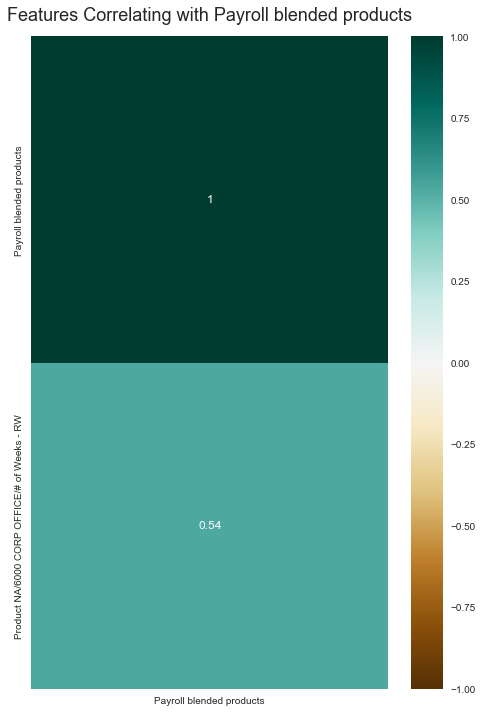

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
from pycaret.regression import *
import pmdarima as pm
from pmdarima.arima import ARIMA
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import import_ipynb
import data_loader as dl

warnings.filterwarnings("ignore")

def run_auto_ml(train_df, test_df, target_col, feature_cols, normal_transform, ml_criteria):
    # Model Definitions
    s = setup(data = train_df, 
              test_data = test_df, 
              target = target_col, 
              fold_strategy = 'timeseries', 
              numeric_features = feature_cols, 
              fold = 3, 
              transform_target = normal_transform,
              feature_selection = True,
              feature_selection_threshold = 0.8,
              remove_multicollinearity = True,
              multicollinearity_threshold = 0.9,
              session_id = 123)
    best = compare_models(sort = ml_criteria)
    results = pull()
    model_results = results.Model.tolist()
    #print(type(best))
    return best

def get_important_features(model, threshold):
    # Get list of features and their values
    features = pd.DataFrame()
    if model == 'xgboost':
        xgb = create_model('xgboost', cross_validation=True, verbose=False)        
        feature_important = xgb.get_booster().get_score(importance_type='gain')
        keys = list(feature_important.keys())
        values = list(feature_important.values())
        features = pd.DataFrame(data=values, index=keys, columns=['Variable Importance']).sort_values(by='Variable Importance', ascending=False)
        features = features[features.index.str.contains('Calendar Date') == False]
        features = features.rename_axis('Feature').reset_index()
        features = features[features.index <= threshold-1]
    return features

def run_auto_arima(df, feature_cols, pred_start_dt, forecast_window):
    pred_df = pd.DataFrame()
    dti = pd.date_range(pred_start_dt, periods=forecast_window, freq="M")
    dti = dti + pd.offsets.MonthBegin(-1)
    pred_df['Calendar Date'] = dti

    for col in feature_cols:
        model = pm.auto_arima(df[col], 
                      start_p=1, 
                      start_q=1, 
                      max_p=5, 
                      max_q=5, 
                      m=12, 
                      start_P=0, 
                      seasonal=True, 
                      d=1, 
                      D=1, 
                      trace=True, 
                      error_action='ignore',  # don't want to know if an order does not work
                      suppress_warnings=True,  # don't want convergence warnings
                      stepwise=True)  # set to stepwise

        # make future predictions
        pred_df[col] = model.predict(n_periods=forecast_window)
    return pred_df

def compute_apes_and_mapes(df, date_col, target_col, feature_cols):
    sort_cols = [date_col, target_col]
    ape_cols = []
    for col in feature_cols:
        ape_col = col+' - APE' 
        df[ape_col] = ((df[target_col] - df[col]).abs())/df[target_col]
        sort_cols.append(col)
        sort_cols.append(ape_col)
        ape_cols.append(ape_col)
    df = df[sort_cols]    
    non_ape_cols = list(set(sort_cols) - set(ape_cols))
    mape_df = df.groupby([True]*len(df)).mean(numeric_only=True)
    mape_df[non_ape_cols] = np.nan
    df = pd.concat([df,mape_df])
    return df  

#########################################################################################
#                              BEGIN PARAMETERS SECTION 
#      This section is where we set the model parameters including:
#      The date ranges for the training, testing and prediction dataframes
#      The features and correlations thresholds, etc
#########################################################################################

# ------------------------------------------------------------------------------------- #
# This is where we change the parameters for the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'

# This is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5

# This is how many features you want to keep in the final model
features_threshold = 10

has_actuals = True

# ------------------------------------------------------------------------------------- #
# Total Payroll Section
# ------------------------------------------------------------------------------------- #
target_col = 'Payroll blended products'
has_drivers = True
#target_col = 'W-2 Revenue'
#has_drivers = False
#target_col = 'Delivery Revenue'
#has_drivers = False
#target_col = 'ASO Allocation'
#has_drivers = False
#target_col = 'Other Processing Revenue'
#has_drivers = False
#target_col = 'SurePayroll.'
#has_drivers = True
#target_col = 'Total international'
#has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total 401K Section
# ------------------------------------------------------------------------------------- #
#target_col = '401K Fee Revenue'
#has_drivers = True
#target_col = '401K Asset fee & BP Revenue'
#has_drivers = True

# ------------------------------------------------------------------------------------- #
# Name the output columns here
# ------------------------------------------------------------------------------------- #
ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
fcst_cols = [ml_col,uts_col,plan_col,fcst_col]


#########################################################################################
#                              END PARAMETERS SECTION 
#########################################################################################

#########################################################################################
#                              BEGIN DATA SECTION 
#             This is where the dataframes get created based on the parameters 
#             set in the previous section. You should not need to change any code 
#             from here below
#########################################################################################

# Get the full data frame and combine with drivers
all_df = dl.get_level_0_data(train_start_dt, pred_end_dt)
all_df = all_df[['Calendar Date', target_col]]
if has_drivers:
    driv_df = dl.get_driver_data(train_start_dt, pred_end_dt, target_col)
    driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')
ext_df = dl.get_external_data(train_start_dt, pred_end_dt)
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

# Train df
train_df = all_df[all_df['Calendar Date'].astype(int) <= int(train_end_dt)]
train_df['Calendar Date'] = pd.to_datetime(train_df['Calendar Date'])
print('Shape of the training dataframe:')
print(train_df.shape)

# Test df
test_df = all_df[(all_df['Calendar Date'].astype(int) >= int(test_start_dt)) & (all_df['Calendar Date'].astype(int) <= int(test_end_dt))]
test_df['Calendar Date'] = pd.to_datetime(test_df['Calendar Date'])
print('Shape of the testing dataframe:')
print(test_df.shape)

# Combined dataframe
comb_df = pd.concat([train_df, test_df])
print('Shape of the combination dataframe:')
print(comb_df.shape)

feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

# Run Correlations to target
corr_df = comb_df.corr()[[target_col]]
corr_df = corr_df[corr_df[target_col].abs() >= correlation_threshold]

# Plot the highest correlated features to the target
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target_col, fontdict={'fontsize':18}, pad=16);

# Get a list of the features based on correlation
corr_df = corr_df.rename_axis('Feature').reset_index()
corr_feature_cols = corr_df['Feature'].tolist()
corr_feature_cols.remove(target_col)    
#print(corr_feature_cols)

# run auto ml and get the most important features
best = run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)
ml_features = get_important_features('xgboost', features_threshold)
ml_feature_cols = ml_features['Feature'].tolist()

if len(ml_features.index) != 0:
    # plot the most important features
    fig = px.bar(ml_features.sort_values('Variable Importance', ascending=True),
                 x='Variable Importance', 
                 y='Feature', 
                 orientation='h', 
                 title='Feature Importance Plot')
    fig.show()
    
# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #

# Here we need to figure out which set of features we want to use
# ml_features or corr_features
feature_cols = ml_feature_cols

keeps = ['Calendar Date', target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
comb_df = comb_df[keeps]

best = run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)    

# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()

# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #

# create the future predictions dataframe
if has_actuals:
    act_df = all_df[all_df['Calendar Date'].astype(int) >= int(pred_start_dt)]
    act_df = act_df[keeps]
    act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])
    pred_df = run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df.rename(columns={'Label':ml_col}, inplace=True)
    concat_df = pd.merge(pred_df,act_df, on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_plan_data(pred_start_dt, pred_end_dt)
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_forecast_data(pred_start_dt, pred_end_dt, forecast_type)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

    # run UTS 
    uts_df = comb_df[['Calendar Date', target_col]]
    uts_df = run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window)
    uts_df.rename(columns={target_col:uts_col}, inplace=True)
    concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')
    
    # combine all data together
    concat_df = pd.concat([comb_df,concat_df], axis=0)
    
    # show plot
    fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
    fig.show()
    
    # compute mape_df
    mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
    mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
    mape_df = compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
    mape_df.rename(index={True:'MAPE'}, inplace=True)
    #print(mape_df)
    data_dir = 'C:/Users/jgillespie/Desktop/Paychex/'
    data_file = 'mapes.xlsx'
    mape_df.to_excel(data_dir+data_file, sheet_name=target_col[0:31])  
    